# LSTM

### LSTM(+ One-hot Encoding)

### 데이터 준비

In [14]:
from tensorflow.keras.datasets import imdb
import torch
import torch.nn.functional as F

VOCAB_SIZE = 300 # 사용할 단어 수
SEQ_LEN = 150    # 시퀀스 하나의 최대 길이

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=VOCAB_SIZE)

# Torch Tensor 변환
train_input = [torch.tensor(seq, dtype=torch.long) for seq in train_input][:10000] 
test_input = [torch.tensor(seq, dtype=torch.long) for seq in test_input][:5000] 

train_target = torch.tensor(train_target, dtype=torch.long)[:10000]
test_target = torch.tensor(test_target, dtype=torch.long)[:5000]

def pad_sequences(sequences, maxlen, padding_value=0):
    padded_sequences = [F.pad(seq[:maxlen], (0, max(0, maxlen-len(seq))), value=padding_value) for seq in sequences]
    return torch.stack(padded_sequences)

train_seq = pad_sequences(train_input, maxlen=SEQ_LEN)
test_seq = pad_sequences(test_input, maxlen=SEQ_LEN)

# one-hot encoding
train_onehot = F.one_hot(train_seq, num_classes=VOCAB_SIZE).float()
test_onehot = F.one_hot(test_seq, num_classes=VOCAB_SIZE).float()

# label 데이터 실수 처리
train_target = train_target.float()
test_target = test_target.float()

train_onehot.shape, test_onehot.shape

(torch.Size([10000, 150, 300]), torch.Size([5000, 150, 300]))

### 학습 함수 정의

In [15]:
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

def train_func(train_data, train_label, model):

    # 배치 사이즈, 학습/검증셋 크기 설정
    BATCH_SIZE = 65
    train_size = int(len(train_data) * 0.8)
    val_size = len(train_data) - train_size



    # 데이터 학습/검증셋 분할
    train_dataset, val_dataset = random_split(TensorDataset(train_data, train_label), [train_size, val_size])
    # 미니배치로 사용할 수 있도록 DataLoader 생성
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    # epoch(학습 횟수), 손실 함수, 최적화 함수 정의
    epochs = 100
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.005)

    # 시각화를 위한 손실값/정확도 저장용 배열 생성
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    # 조기종료 관련 변수 초기화
    early_stopping_patience = 7
    best_val_loss = float('inf')
    early_stop_counter = 0

    # 학습 과정
    for epoch in range(epochs):
        # 학습 모드
        model.train()
        total_loss, correct, total = 0, 0, 0

        for inputs, targets in train_loader:
            optimizer.zero_grad()               # 가중치 초기화
            outputs = model(inputs).squeeze()   # 순전파

            loss = criterion(outputs, targets)  # 손실 계산

            loss.backward()                     # 역전파
            optimizer.step()                    # 가중치 갱신
            total_loss += loss.item()

            pred = (outputs > 0.5).float()
            correct += (pred == targets).sum().item()
            total += targets.size(0)

        train_loss = total_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
            
        # 검증 모드
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0

        with torch.no_grad():
            for val_inputs, val_targets in val_loader:
                val_outputs = model(val_inputs).squeeze()   # 순전파
                loss = criterion(val_outputs, val_targets)  # 손실 계산
                val_loss += loss.item()

                val_pred = (val_outputs > 0.5).float()
                val_correct += (val_pred == val_targets).sum().item()
                val_total += val_targets.size(0)

        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)    

        print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # 조기종료 처리
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= early_stopping_patience:
                print("Early stopping!!!")
                break

    train_history_df = pd.DataFrame({
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_acc': train_accs,
        'val_accs': val_accs
    })

    train_history_df.plot()
    plt.show()

### 평가 함수 정의

In [16]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for val_inputs, val_targets in test_loader:
            val_outputs = model(val_inputs).squeeze()   # 순전파
            loss = criterion(val_outputs, val_targets)  # 손실 계산
            val_loss += loss.item()

            val_pred = (val_outputs > 0.5).float()
            val_correct += (val_pred == val_targets).sum().item()
            val_total += val_targets.size(0)

    test_loss = val_loss / len(test_loader)
    test_acc = val_correct / val_total
    return test_loss, test_acc
  

### 모델 준비 및 학습

### LSTM

In [17]:
import torch
import torch.nn as nn

class SentimentLSTM(nn.Module):

    def __init__(self, seq_len, vocab_size, hidden_dim, output_dim):
        super(SentimentLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=vocab_size, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])
        return self.sigmoid(out)

In [18]:
HIDDEN_DIM = 8
OUTPUT_DIM = 1

lstm_model = SentimentLSTM(
    seq_len=SEQ_LEN,
    vocab_size= VOCAB_SIZE,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM
)

print(lstm_model)

SentimentLSTM(
  (lstm): LSTM(300, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Epoch 1/100 | Train Loss: 0.6931, Train Acc: 0.5041, Val Loss: 0.6937, Val Acc: 0.5010
Epoch 2/100 | Train Loss: 0.6889, Train Acc: 0.5385, Val Loss: 0.6927, Val Acc: 0.5230
Epoch 3/100 | Train Loss: 0.6763, Train Acc: 0.5697, Val Loss: 0.6805, Val Acc: 0.5760
Epoch 4/100 | Train Loss: 0.6717, Train Acc: 0.5999, Val Loss: 0.6945, Val Acc: 0.5180
Epoch 5/100 | Train Loss: 0.6911, Train Acc: 0.5174, Val Loss: 0.6942, Val Acc: 0.4970
Epoch 6/100 | Train Loss: 0.6850, Train Acc: 0.5435, Val Loss: 0.6947, Val Acc: 0.5220
Epoch 7/100 | Train Loss: 0.6761, Train Acc: 0.5671, Val Loss: 0.7036, Val Acc: 0.5210
Epoch 8/100 | Train Loss: 0.6650, Train Acc: 0.5830, Val Loss: 0.6713, Val Acc: 0.5875
Epoch 9/100 | Train Loss: 0.6176, Train Acc: 0.6593, Val Loss: 0.5602, Val Acc: 0.7225
Epoch 10/100 | Train Loss: 0.5150, Train Acc: 0.7458, Val Loss: 0.5220, Val Acc: 0.7410
Epoch 11/100 | Train Loss: 0.4868, Train Acc: 0.7641, Val Loss: 0.5137, Val Acc: 0.7455
Epoch 12/100 | Train Loss: 0.4767, Train 

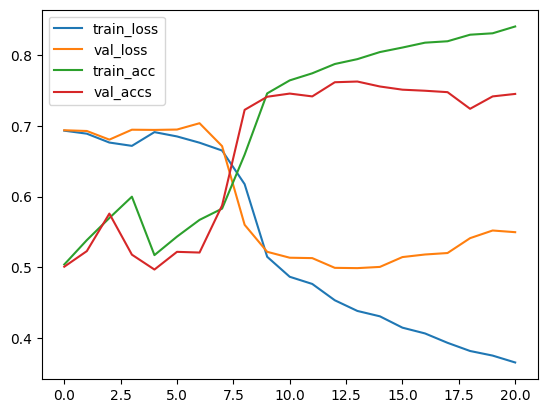

In [19]:
train_func(train_onehot, train_target, lstm_model)

In [20]:
test_dataset = TensorDataset(test_onehot, test_target)
test_loader = DataLoader(test_dataset, batch_size=65)

criterion = nn.BCELoss()

loss, accuracy = evaluate_model(lstm_model, test_loader, criterion)
loss, accuracy

(0.553022539847857, 0.7416)

### LSTM (+ Embedding)

In [30]:
import torch
import torch.nn as nn

class EBDSentimentLSTM(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(EBDSentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])
        return self.sigmoid(out)

In [37]:
HIDDEN_DIM = 8
OUTPUT_DIM = 1
EMBEDDING_DIM = 50


ebd_lstm_model = EBDSentimentLSTM(
    vocab_size= VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM
)

print(ebd_lstm_model)

EBDSentimentLSTM(
  (embedding): Embedding(300, 50)
  (lstm): LSTM(50, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Epoch 1/100 | Train Loss: 0.6952, Train Acc: 0.4978, Val Loss: 0.6919, Val Acc: 0.5260
Epoch 2/100 | Train Loss: 0.6873, Train Acc: 0.5454, Val Loss: 0.6907, Val Acc: 0.5255
Epoch 3/100 | Train Loss: 0.6763, Train Acc: 0.5697, Val Loss: 0.6874, Val Acc: 0.5365
Epoch 4/100 | Train Loss: 0.6586, Train Acc: 0.5951, Val Loss: 0.6816, Val Acc: 0.5630
Epoch 5/100 | Train Loss: 0.6349, Train Acc: 0.6179, Val Loss: 0.6733, Val Acc: 0.5765
Epoch 6/100 | Train Loss: 0.5958, Train Acc: 0.6726, Val Loss: 0.6342, Val Acc: 0.6720
Epoch 7/100 | Train Loss: 0.5479, Train Acc: 0.7355, Val Loss: 0.6044, Val Acc: 0.6950
Epoch 8/100 | Train Loss: 0.5061, Train Acc: 0.7638, Val Loss: 0.6047, Val Acc: 0.6980
Epoch 9/100 | Train Loss: 0.4887, Train Acc: 0.7735, Val Loss: 0.6026, Val Acc: 0.7085
Epoch 10/100 | Train Loss: 0.4606, Train Acc: 0.7859, Val Loss: 0.6287, Val Acc: 0.7035
Epoch 11/100 | Train Loss: 0.4458, Train Acc: 0.8005, Val Loss: 0.6167, Val Acc: 0.7030
Epoch 12/100 | Train Loss: 0.4301, Train 

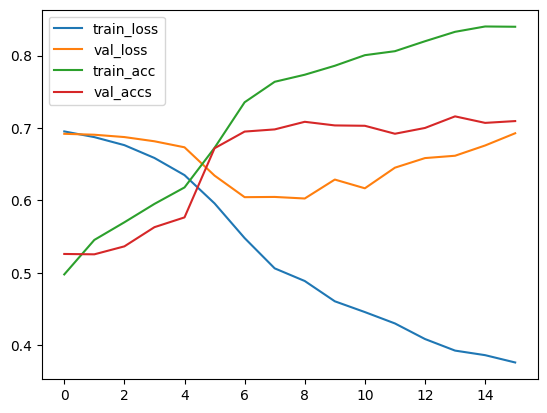

In [38]:
train_func(train_seq.to(torch.long), train_target, ebd_lstm_model)

In [39]:
test_dataset = TensorDataset(test_seq.to(torch.long), test_target)
test_loader = DataLoader(test_dataset, batch_size=65)

criterion = nn.BCELoss()

loss, accuracy = evaluate_model(ebd_lstm_model, test_loader, criterion)
loss, accuracy

(0.6676838510222249, 0.7126)

### Stacked LSTM (Embedding + LSTM + LSTM)

In [46]:
class StackedSentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(StackedSentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, 
                                      embedding_dim=embedding_dim)
        self.lstm1 = nn.LSTM(input_size=embedding_dim, 
                             hidden_size=hidden_dim, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=hidden_dim, 
                             hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm1(x)
        _, (hidden, _) = self.lstm2(x)
        out = self.fc(hidden)
        return self.sigmoid(out) 

In [47]:
HIDDEN_DIM = 8
OUTPUT_DIM = 1
EMBEDDING_DIM = 50


stacked_lstm_model = StackedSentimentLSTM(
    vocab_size= VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM
)

print(stacked_lstm_model)

StackedSentimentLSTM(
  (embedding): Embedding(300, 50)
  (lstm1): LSTM(50, 8, batch_first=True)
  (lstm2): LSTM(8, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Epoch 1/100 | Train Loss: 0.6934, Train Acc: 0.5014, Val Loss: 0.6933, Val Acc: 0.5035
Epoch 2/100 | Train Loss: 0.6878, Train Acc: 0.5316, Val Loss: 0.6914, Val Acc: 0.5410
Epoch 3/100 | Train Loss: 0.6712, Train Acc: 0.5741, Val Loss: 0.6807, Val Acc: 0.5555
Epoch 4/100 | Train Loss: 0.6493, Train Acc: 0.6236, Val Loss: 0.6668, Val Acc: 0.6325
Epoch 5/100 | Train Loss: 0.6327, Train Acc: 0.6479, Val Loss: 0.6766, Val Acc: 0.6115
Epoch 6/100 | Train Loss: 0.6647, Train Acc: 0.6150, Val Loss: 0.6633, Val Acc: 0.6215
Epoch 7/100 | Train Loss: 0.6276, Train Acc: 0.6664, Val Loss: 0.6611, Val Acc: 0.6325
Epoch 8/100 | Train Loss: 0.6073, Train Acc: 0.6844, Val Loss: 0.6465, Val Acc: 0.6510
Epoch 9/100 | Train Loss: 0.5933, Train Acc: 0.7010, Val Loss: 0.6451, Val Acc: 0.6575
Epoch 10/100 | Train Loss: 0.5893, Train Acc: 0.7090, Val Loss: 0.6533, Val Acc: 0.6465
Epoch 11/100 | Train Loss: 0.5869, Train Acc: 0.7080, Val Loss: 0.6344, Val Acc: 0.6715
Epoch 12/100 | Train Loss: 0.5771, Train 

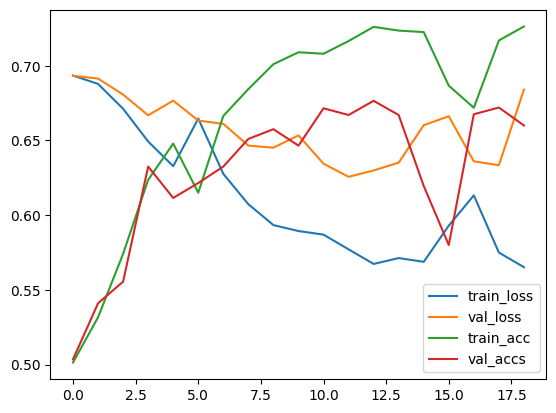

In [48]:
train_func(train_seq.to(torch.long), train_target, stacked_lstm_model)

In [49]:
test_dataset = TensorDataset(test_seq.to(torch.long), test_target)
test_loader = DataLoader(test_dataset, batch_size=65)

criterion = nn.BCELoss()

loss, accuracy = evaluate_model(stacked_lstm_model, test_loader, criterion)
loss, accuracy

(0.6824262010586726, 0.656)

### Stacked LSTM (Embedding + LSTM + LSTM + Dropout)